<Figure size 800x500 with 0 Axes>

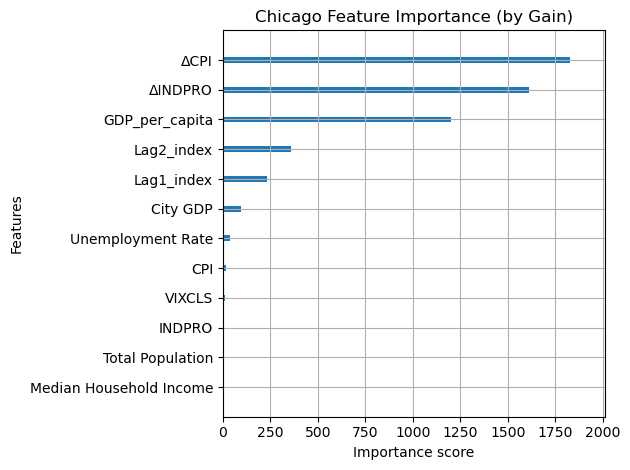


===== Chicago =====
Test R²: 0.4405
MAE: 10.8523
RMSE: 15.7139


<Figure size 800x500 with 0 Axes>

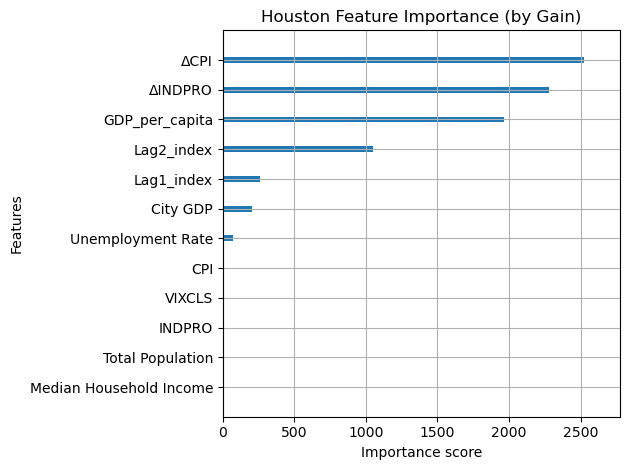


===== Houston =====
Test R²: -2.1064
MAE: 60.2345
RMSE: 73.1201


<Figure size 800x500 with 0 Axes>

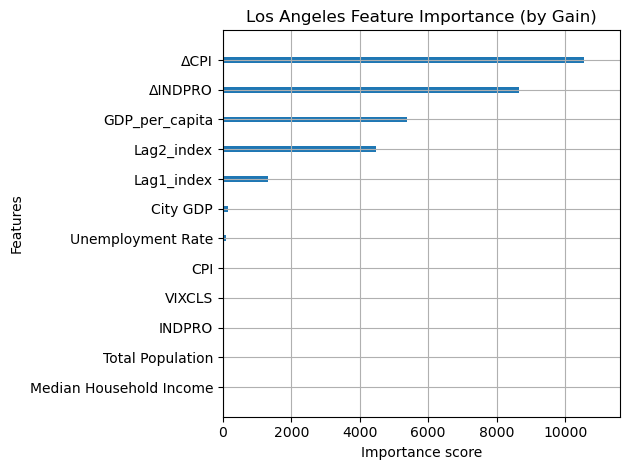


===== Los Angeles =====
Test R²: -0.9892
MAE: 65.7193
RMSE: 90.9203


<Figure size 800x500 with 0 Axes>

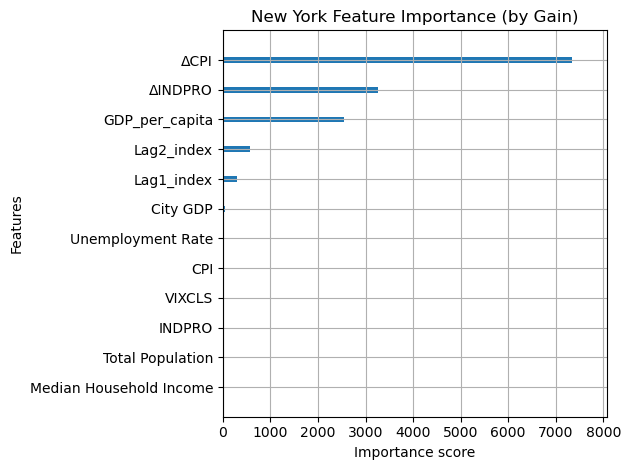


===== New York =====
Test R²: -1.3818
MAE: 42.3106
RMSE: 55.0029


<Figure size 800x500 with 0 Axes>

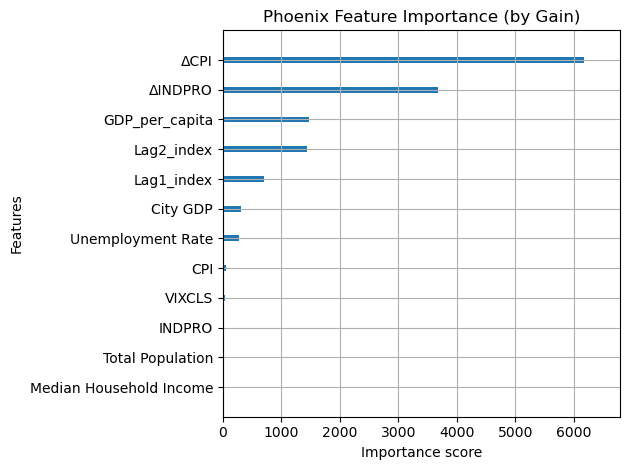


===== Phoenix =====
Test R²: -0.4237
MAE: 69.1277
RMSE: 100.7149

===== Summary of All Cities =====
          City        R²        MAE        RMSE
0      Chicago  0.440493  10.852292   15.713860
4      Phoenix -0.423691  69.127675  100.714943
2  Los Angeles -0.989236  65.719284   90.920258
3     New York -1.381766  42.310589   55.002915
1      Houston -2.106429  60.234533   73.120068


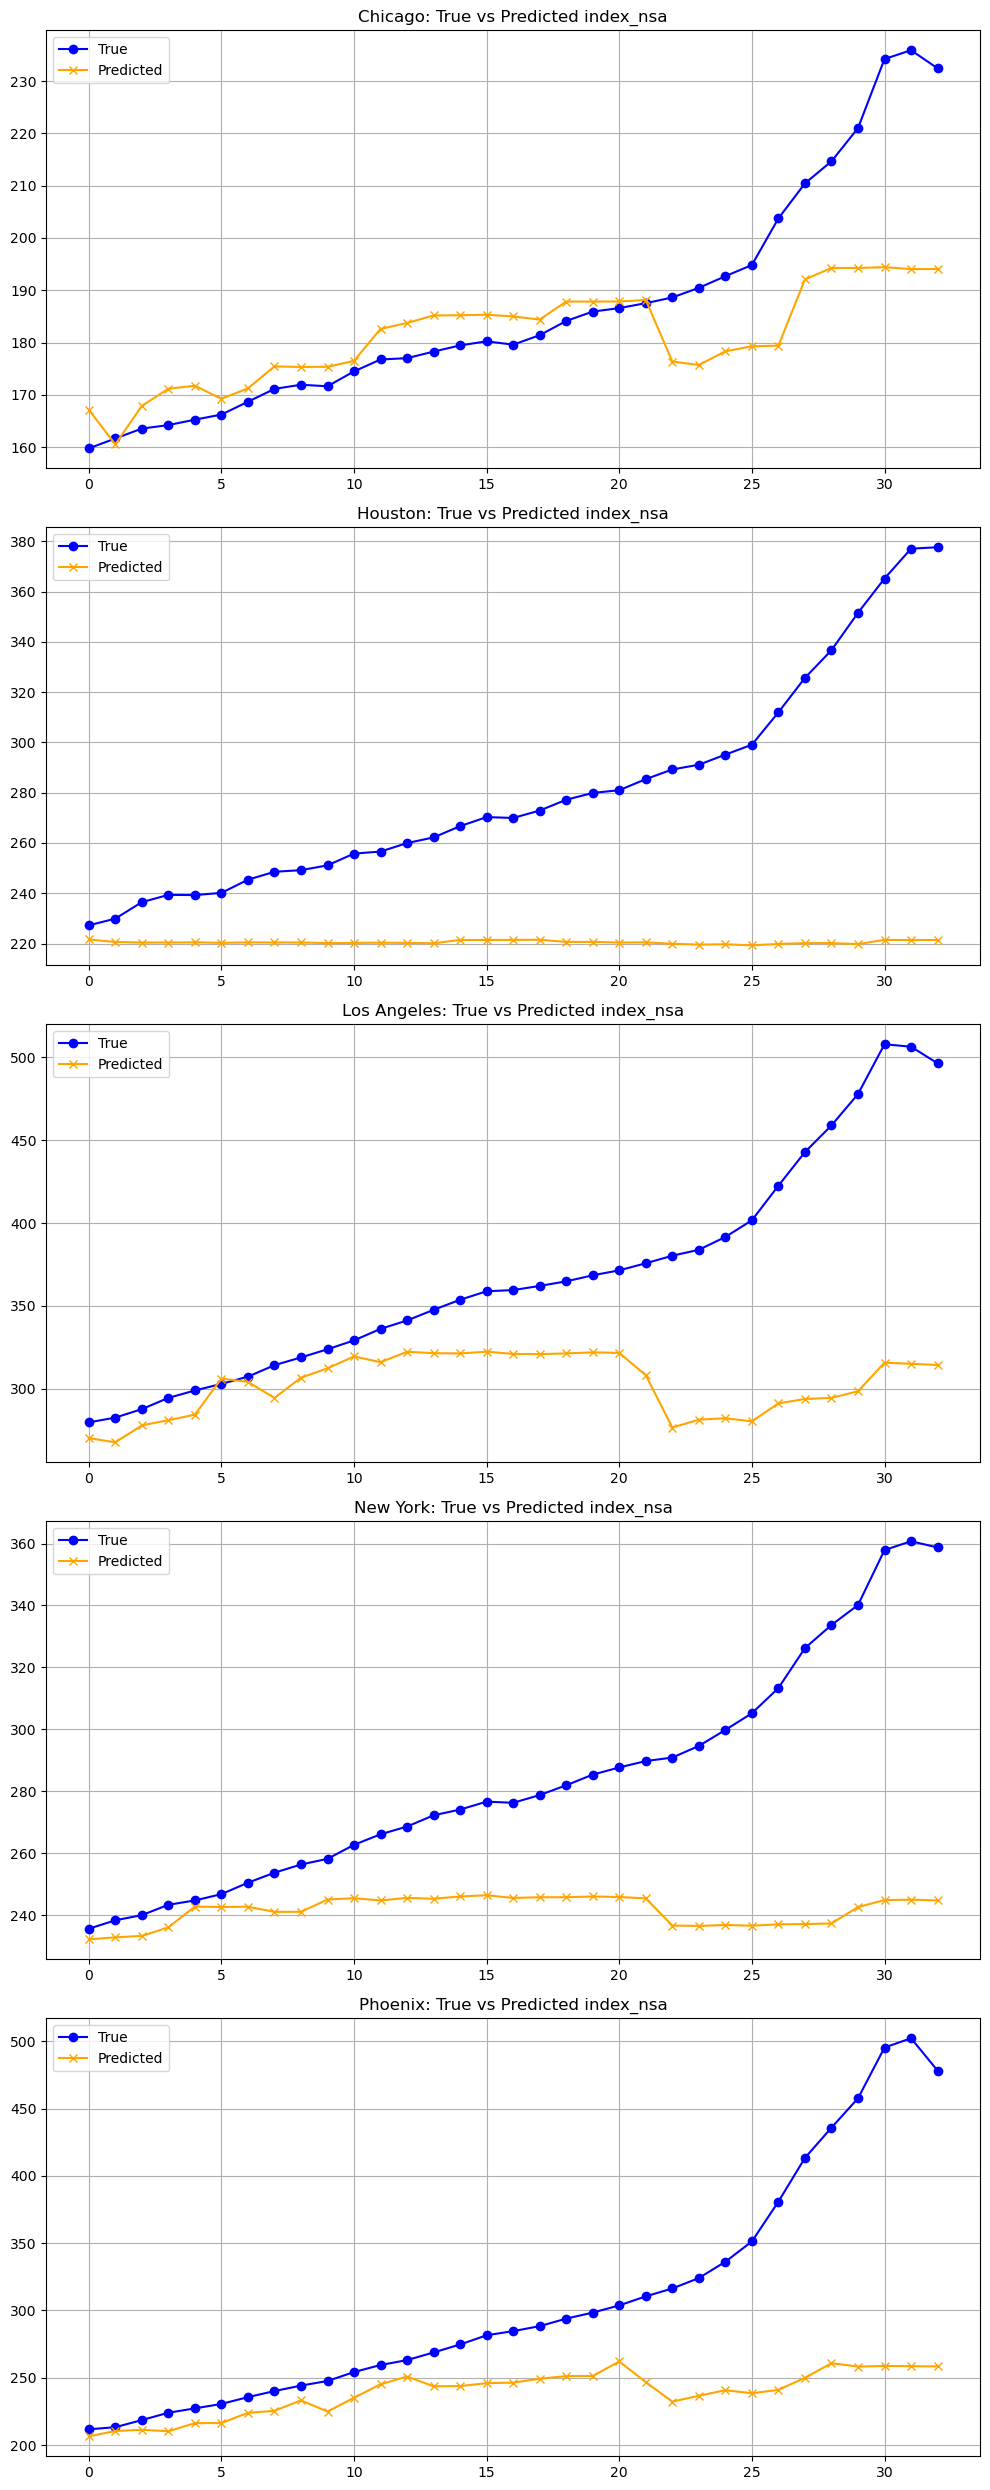

In [ ]:

import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
''''''
df = pd.read_csv('../final_merged_output.csv')

df.columns = df.columns.str.strip()

df = df.sort_values(['City', 'Year', 'Quarter']).reset_index(drop=True)

def model_for_city(city_df, city_name):
    city_df = city_df.copy()

    
    city_df['Lag1_index'] = city_df['index_nsa'].shift(1)
    city_df['Lag2_index'] = city_df['index_nsa'].shift(2)


    city_df['GDP_per_capita'] = city_df['City GDP'] / city_df['Total Population']
    city_df['ΔINDPRO'] = city_df['INDPRO'].diff()
    city_df['ΔCPI'] = city_df['CPI'].diff()


    city_df = city_df.dropna()


    features = [
        'Median Household Income', 'Total Population', 'INDPRO', 'VIXCLS', 'CPI',
        'Unemployment Rate', 'City GDP', 'Lag1_index', 'Lag2_index',
        'GDP_per_capita', 'ΔINDPRO', 'ΔCPI'
    ]
    X = city_df[features]
    y = city_df['index_nsa']

    split_idx = int(len(city_df) * 0.75)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    '''train_df = city_df[city_df['Year'] <= 2021]
    test_df = city_df[city_df['Year'] == 2022]

    X_train = train_df[features]
    y_train = train_df['index_nsa']
    X_test = test_df[features]
    y_test = test_df['index_nsa']'''


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_lambda=1.0,   # L2 regularization
        reg_alpha=0.5,    # L1 regularization
        random_state=42
    )

    # model training
    model.fit(X_train_scaled, y_train)


    plt.figure(figsize=(8, 5))
    plot_importance(model, importance_type='gain', show_values=False)
    ax = plt.gca()
    ax.set_yticklabels(features)  # replace f0, f1, ... 
    plt.title(f"{city_name} Feature Importance (by Gain)")
    plt.tight_layout()
    plt.show()

    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n===== {city_name} =====")
    print("Test R²:", round(r2, 4))
    print("MAE:", round(mae, 4))
    print("RMSE:", round(rmse, 4))

    return {
        'City': city_name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Model': model,
        'y_test': y_test,
        'y_pred': y_pred
    }

'''train by city'''
results = []
for city in df['City'].unique():
    city_df = df[df['City'] == city]
    result = model_for_city(city_df, city)
    results.append(result)


metrics_df = pd.DataFrame([
    {'City': r['City'], 'R²': r['R²'], 'MAE': r['MAE'], 'RMSE': r['RMSE']}
    for r in results
])

print("\n===== Summary of All Cities =====")
print(metrics_df.sort_values('R²', ascending=False))


num_cities = len(results)
fig, axes = plt.subplots(num_cities, 1, figsize=(10, 5 * num_cities), sharex=False)

if num_cities == 1:
    axes = [axes]  

for i, r in enumerate(results):
    city = r['City']
    y_test = r['y_test'].values
    y_pred = r['y_pred']

    axes[i].plot(y_test, label='True', marker='o', color='blue')
    axes[i].plot(y_pred, label='Predicted', marker='x', color='orange')
    axes[i].set_title(f"{city}: True vs Predicted index_nsa", fontsize=12)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

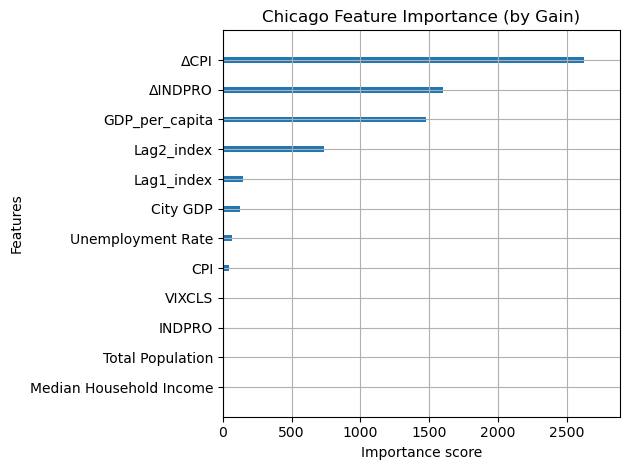


===== Chicago =====
Test R²: -11.0462
MAE: 19.3178
RMSE: 20.2408


<Figure size 800x500 with 0 Axes>

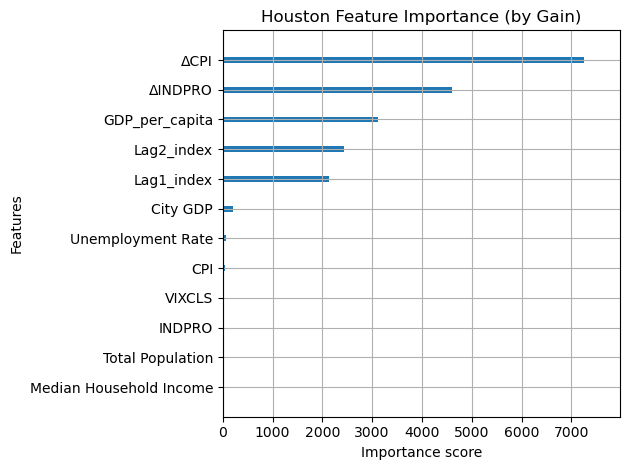


===== Houston =====
Test R²: -10.3177
MAE: 34.2425
RMSE: 35.8235


<Figure size 800x500 with 0 Axes>

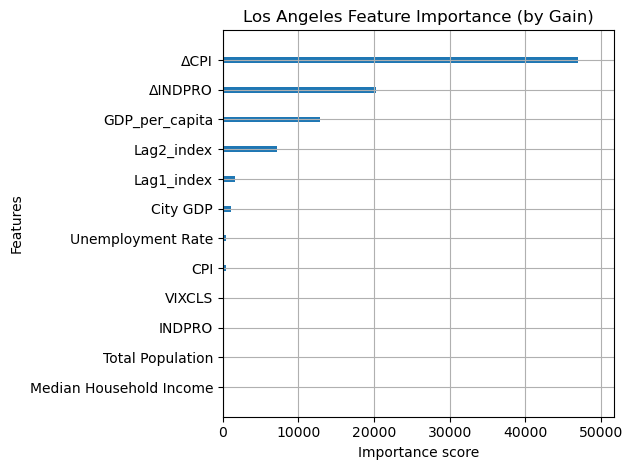


===== Los Angeles =====
Test R²: -15.0711
MAE: 46.0848
RMSE: 48.0368


<Figure size 800x500 with 0 Axes>

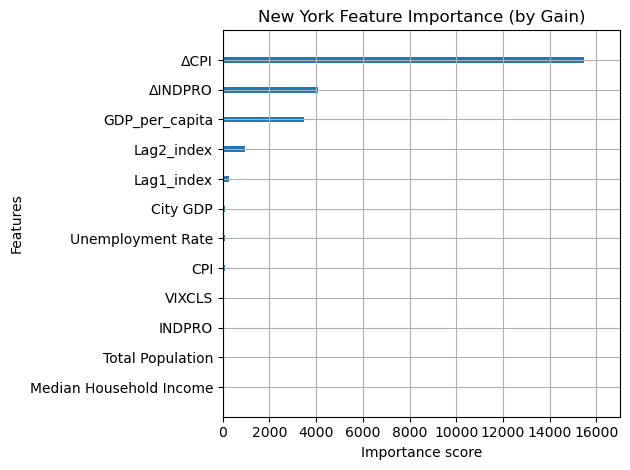


===== New York =====
Test R²: -12.4998
MAE: 29.2423
RMSE: 30.4513


<Figure size 800x500 with 0 Axes>

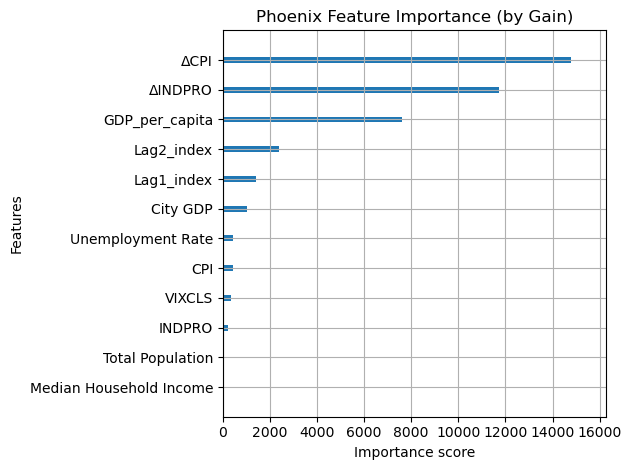


===== Phoenix =====
Test R²: -9.8761
MAE: 53.9881
RMSE: 56.8524

===== Summary of All Cities =====
          City         R²        MAE       RMSE
4      Phoenix  -9.876073  53.988067  56.852445
1      Houston -10.317672  34.242501  35.823490
0      Chicago -11.046240  19.317758  20.240811
3     New York -12.499785  29.242272  30.451299
2  Los Angeles -15.071058  46.084757  48.036801


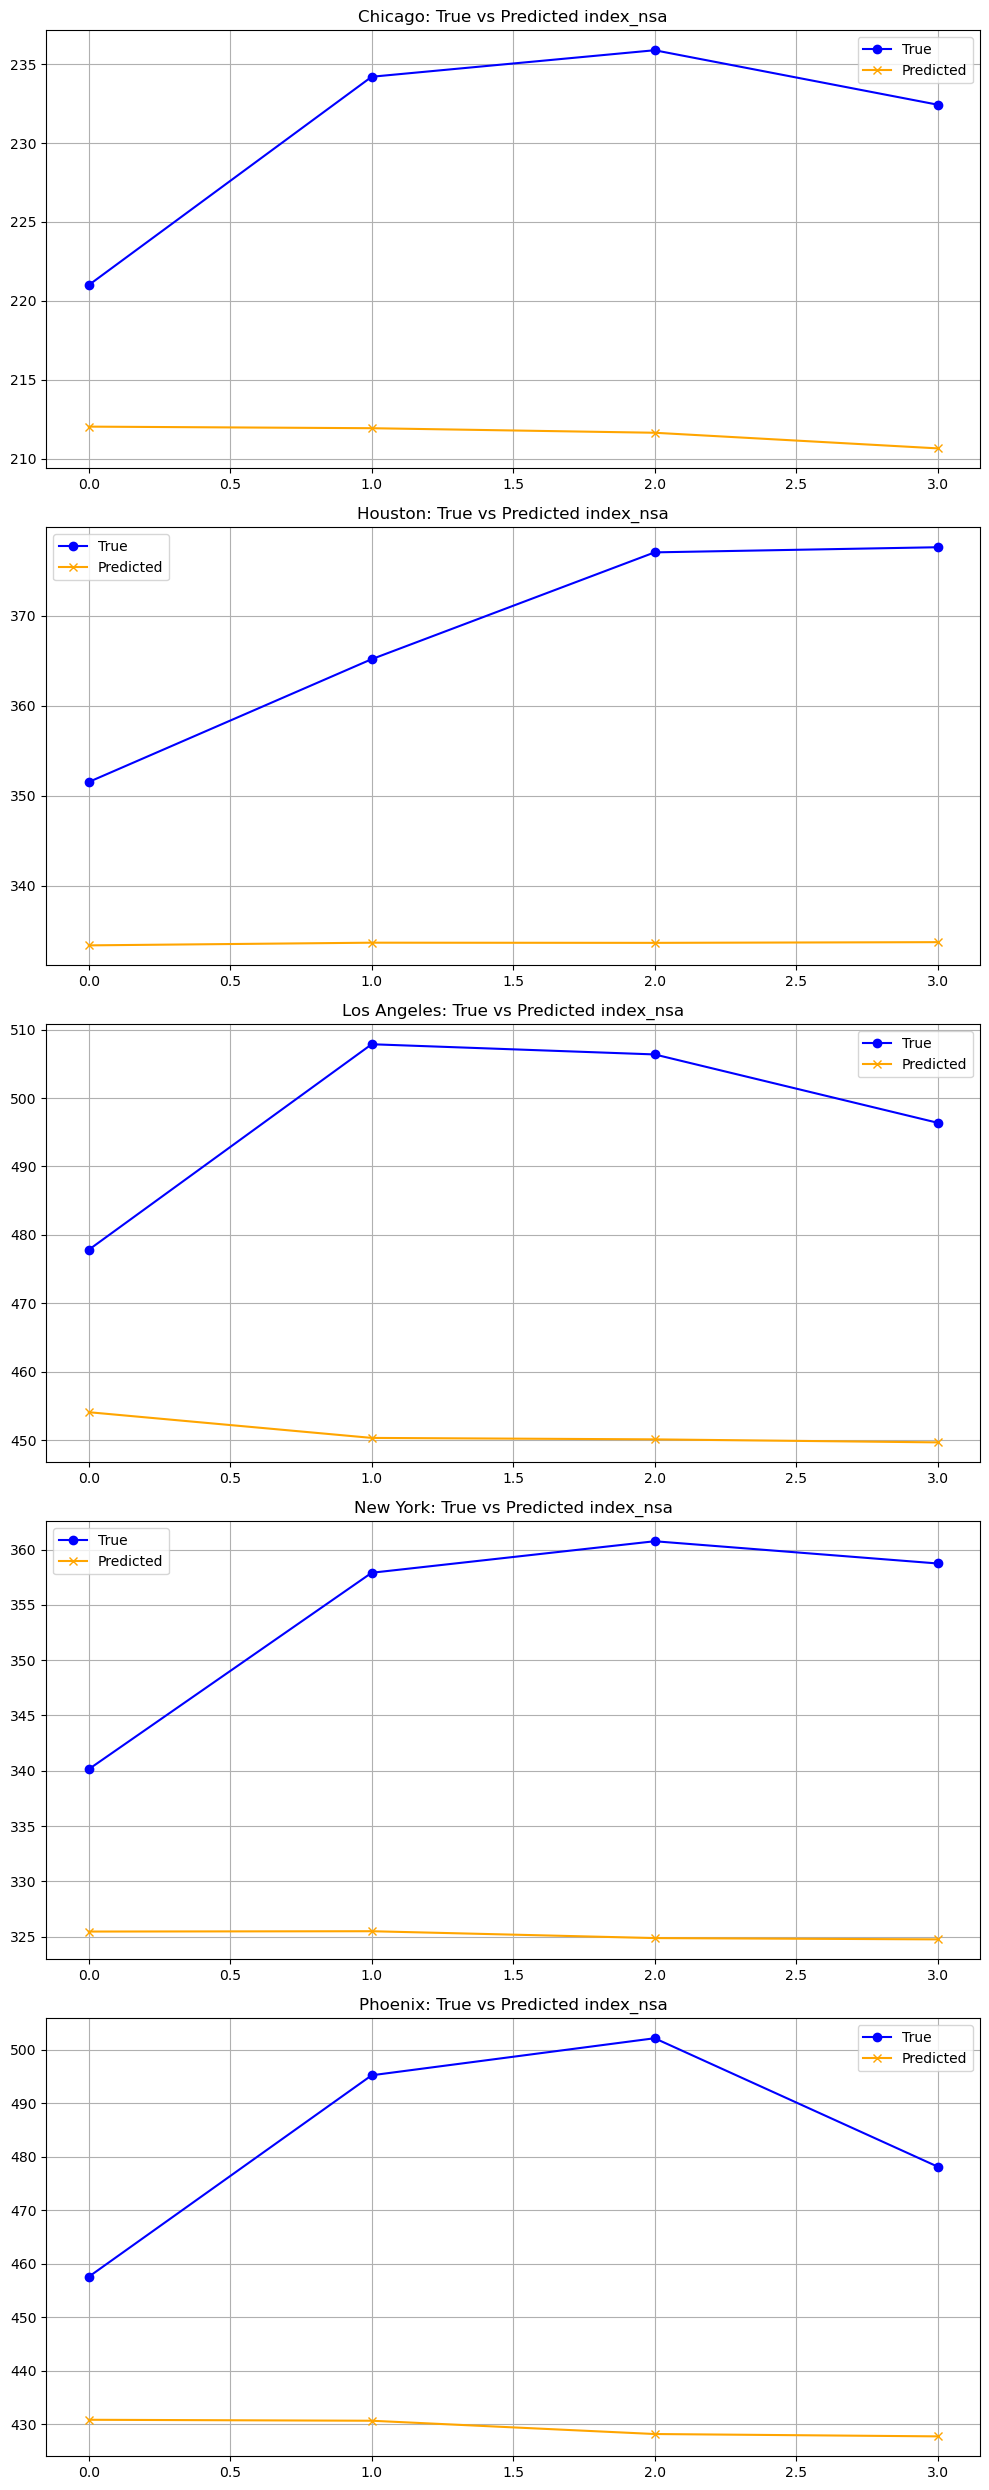

In [3]:

import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv('../final_merged_output.csv')

df.columns = df.columns.str.strip()

df = df.sort_values(['City', 'Year', 'Quarter']).reset_index(drop=True)

def model_for_city(city_df, city_name):
    city_df = city_df.copy()

    
    city_df['Lag1_index'] = city_df['index_nsa'].shift(1)
    city_df['Lag2_index'] = city_df['index_nsa'].shift(2)


    city_df['GDP_per_capita'] = city_df['City GDP'] / city_df['Total Population']
    city_df['ΔINDPRO'] = city_df['INDPRO'].diff()
    city_df['ΔCPI'] = city_df['CPI'].diff()


    city_df = city_df.dropna()


    features = [
        'Median Household Income', 'Total Population', 'INDPRO', 'VIXCLS', 'CPI',
        'Unemployment Rate', 'City GDP', 'Lag1_index', 'Lag2_index',
        'GDP_per_capita', 'ΔINDPRO', 'ΔCPI'
    ]
    X = city_df[features]
    y = city_df['index_nsa']


    '''split_idx = int(len(city_df) * 0.75)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]'''

    train_df = city_df[city_df['Year'] <= 2021]
    test_df = city_df[city_df['Year'] == 2022]

    X_train = train_df[features]
    y_train = train_df['index_nsa']
    X_test = test_df[features]
    y_test = test_df['index_nsa']


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_lambda=1.0,   # L2 regularization
        reg_alpha=0.5,    # L1 regularization
        random_state=42
    )

    # model training
    model.fit(X_train_scaled, y_train)


    plt.figure(figsize=(8, 5))
    plot_importance(model, importance_type='gain', show_values=False)
    ax = plt.gca()
    ax.set_yticklabels(features)  # replace f0, f1, ... 
    plt.title(f"{city_name} Feature Importance (by Gain)")
    plt.tight_layout()
    plt.show()

    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n===== {city_name} =====")
    print("Test R²:", round(r2, 4))
    print("MAE:", round(mae, 4))
    print("RMSE:", round(rmse, 4))

    return {
        'City': city_name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Model': model,
        'y_test': y_test,
        'y_pred': y_pred
    }

'''train by city'''
results = []
for city in df['City'].unique():
    city_df = df[df['City'] == city]
    result = model_for_city(city_df, city)
    results.append(result)


metrics_df = pd.DataFrame([
    {'City': r['City'], 'R²': r['R²'], 'MAE': r['MAE'], 'RMSE': r['RMSE']}
    for r in results
])

print("\n===== Summary of All Cities =====")
print(metrics_df.sort_values('R²', ascending=False))


num_cities = len(results)
fig, axes = plt.subplots(num_cities, 1, figsize=(10, 5 * num_cities), sharex=False)

if num_cities == 1:
    axes = [axes]  

for i, r in enumerate(results):
    city = r['City']
    y_test = r['y_test'].values
    y_pred = r['y_pred']

    axes[i].plot(y_test, label='True', marker='o', color='blue')
    axes[i].plot(y_pred, label='Predicted', marker='x', color='orange')
    axes[i].set_title(f"{city}: True vs Predicted index_nsa", fontsize=12)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()
